In [2]:
import time
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer
import os
import torch
import glob
from skimage.transform import resize

In [3]:
import matplotlib.pyplot as plt

In [1]:
import numpy as np

In [16]:
np.random.randint(0,2)

0

In [4]:
import argparse

In [5]:
os.path

<module 'posixpath' from '/root/anaconda3/lib/python3.7/posixpath.py'>

In [6]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

In [7]:
parser.add_argument('--dataroot', default='./DTU_UnrealDTU', help='path to images (should have subfolders trainA, trainB, valA, valB, etc)')
parser.add_argument('--name', type=str, default='experiment_name', help='name of the experiment. It decides where to store samples and models')
parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints', help='models are saved here')
# model parameters
parser.add_argument('--model', type=str, default='cycle_gan', help='chooses which model to use. [cycle_gan | pix2pix | test | colorization]')
parser.add_argument('--input_nc', type=int, default=1, help='# of input image channels: 3 for RGB and 1 for grayscale')
parser.add_argument('--output_nc', type=int, default=1, help='# of output image channels: 3 for RGB and 1 for grayscale')
parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in the last conv layer')
parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in the first conv layer')
parser.add_argument('--netD', type=str, default='basic', help='specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator')
parser.add_argument('--netG', type=str, default='resnet_9blocks', help='specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]')
parser.add_argument('--n_layers_D', type=int, default=3, help='only used if netD==n_layers')
parser.add_argument('--norm', type=str, default='instance', help='instance normalization or batch normalization [instance | batch | none]')
parser.add_argument('--init_type', type=str, default='normal', help='network initialization [normal | xavier | kaiming | orthogonal]')
parser.add_argument('--init_gain', type=float, default=0.02, help='scaling factor for normal, xavier and orthogonal.')
parser.add_argument('--no_dropout', action='store_true', help='no dropout for the generator')
# dataset parameters
parser.add_argument('--dataset_mode', type=str, default='unaligned', help='chooses how datasets are loaded. [unaligned | aligned | single | colorization]')
parser.add_argument('--direction', type=str, default='AtoB', help='AtoB or BtoA')
parser.add_argument('--serial_batches', action='store_true', help='if true, takes images in order to make batches, otherwise takes them randomly')
parser.add_argument('--num_threads', default=4, type=int, help='# threads for loading data')
parser.add_argument('--batch_size', type=int, default=1, help='input batch size')
parser.add_argument('--load_size', type=int, default=286, help='scale images to this size')
parser.add_argument('--crop_size', type=int, default=256, help='then crop to this size')
parser.add_argument('--max_dataset_size', type=int, default=float("inf"), help='Maximum number of samples allowed per dataset. If the dataset directory contains more than max_dataset_size, only a subset is loaded.')
parser.add_argument('--preprocess', type=str, default='resize_and_crop', help='scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]')
parser.add_argument('--no_flip', action='store_true', help='if specified, do not flip the images for data augmentation')
parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')
# additional parameters
parser.add_argument('--epoch', type=str, default='latest', help='which epoch to load? set to latest to use latest cached model')
parser.add_argument('--load_iter', type=int, default='0', help='which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]')
parser.add_argument('--verbose', action='store_true', help='if specified, print more debugging information')
parser.add_argument('--suffix', default='', type=str, help='customized suffix: opt.name = opt.name + suffix: e.g., {model}_{netG}_size{load_size}')

parser.add_argument('--display_freq', type=int, default=400, help='frequency of showing training results on screen')
parser.add_argument('--display_ncols', type=int, default=4, help='if positive, display all images in a single visdom web panel with certain number of images per row.')
parser.add_argument('--display_id', type=int, default=0, help='window id of the web display')
parser.add_argument('--display_server', type=str, default="http://localhost", help='visdom server of the web display')
parser.add_argument('--display_env', type=str, default='main', help='visdom display environment name (default is "main")')
parser.add_argument('--display_port', type=int, default=8097, help='visdom port of the web display')
parser.add_argument('--update_html_freq', type=int, default=1000, help='frequency of saving training results to html')
parser.add_argument('--print_freq', type=int, default=100, help='frequency of showing training results on console')
parser.add_argument('--no_html', action='store_true', help='do not save intermediate training results to [opt.checkpoints_dir]/[opt.name]/web/')
# network saving and loading parameters
parser.add_argument('--save_latest_freq', type=int, default=5000, help='frequency of saving the latest results')
parser.add_argument('--save_epoch_freq', type=int, default=5, help='frequency of saving checkpoints at the end of epochs')
parser.add_argument('--save_by_iter', action='store_true', help='whether saves model by iteration')
parser.add_argument('--continue_train', action='store_true', help='continue training: load the latest model')
parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
parser.add_argument('--phase', type=str, default='train', help='train, val, test, etc')
# training parameters
parser.add_argument('--n_epochs', type=int, default=100, help='number of epochs with the initial learning rate')
parser.add_argument('--n_epochs_decay', type=int, default=100, help='number of epochs to linearly decay learning rate to zero')
parser.add_argument('--beta1', type=float, default=0.5, help='momentum term of adam')
parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')
parser.add_argument('--gan_mode', type=str, default='lsgan', help='the type of GAN objective. [vanilla| lsgan | wgangp]. vanilla GAN loss is the cross-entropy objective used in the original GAN paper.')
parser.add_argument('--pool_size', type=int, default=50, help='the size of image buffer that stores previously generated images')
parser.add_argument('--lr_policy', type=str, default='linear', help='learning rate policy. [linear | step | plateau | cosine]')
parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')

parser.add_argument('--isTrain', type=bool, default=True, help='multiply by a gamma every lr_decay_iters iterations')

parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
parser.add_argument('--lambda_identity', type=float, default=0.5, help='use identity mapping. Setting lambda_identity other than 0 has an effect of scaling the weight of the identity mapping loss. For example, if the weight of the identity loss should be 10 times smaller than the weight of the reconstruction loss, please set lambda_identity = 0.1')
parser.set_defaults(no_dropout=True) 

In [8]:
opt, _ = parser.parse_known_args()

In [11]:
str_ids = opt.gpu_ids.split(',')
opt.gpu_ids = []
for str_id in str_ids:
    id = int(str_id)
    if id >= 0:
        opt.gpu_ids.append(id)
if len(opt.gpu_ids) > 0:
    torch.cuda.set_device(opt.gpu_ids[0])


In [6]:
from skimage import io

In [7]:
import imageio

In [8]:
# imageio.plugins.freeimage.download()

In [34]:
# im = imageio.imread('~/data/UnrealDTU/Depth/0.125/scan63/rect_004_points.png')
# im = imageio.imread('~/data/DTU/Depths/scan100_train/rect_000_points.png')
im = io.imread('~/data/DTU/Depths/scan100_train/depth_map_0003.pfm')
# im = imageio.imread('~/data/DTU/Rectified/scan100_train/rect_001_0_r5000.png') 

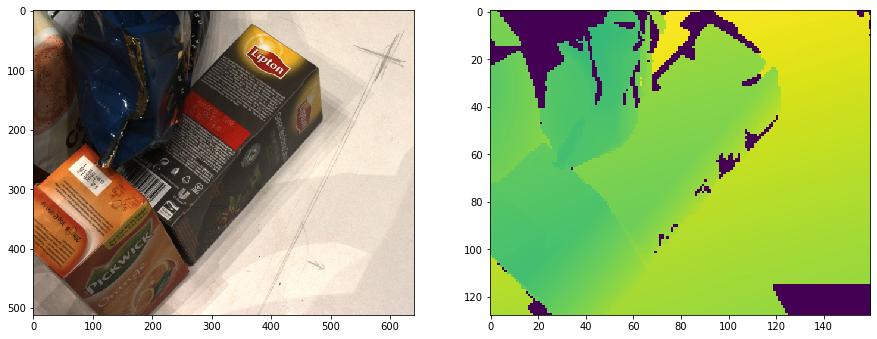

In [78]:
im = imageio.imread('~/data/DTU/Rectified/scan100_train/rect_001_3_r5000.png') 
de = io.imread('~/data/DTU/Depths/scan100_train/depth_map_0000.pfm') 

# im = imageio.imread('~/data/UnrealDTU/Rectified_rescaled/0.25/scan1/rect_012_max.png') 
# de = io.imread('~/data/UnrealDTU/Depth/0.25/scan1/rect_012_points.png') 

fig = plt.figure(figsize = (15,10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(de[::-1])
plt.show()

In [79]:
de[::-1]

array([[695.66254, 696.1259 , 695.46094, ...,   0.     ,   0.     ,
          0.     ],
       [694.9545 , 695.30096, 695.67004, ..., 841.25793, 841.0492 ,
          0.     ],
       [694.189  , 694.4249 , 695.01776, ..., 840.26373, 840.0074 ,
        839.4564 ],
       ...,
       [764.513  , 764.24585, 763.9982 , ...,   0.     ,   0.     ,
          0.     ],
       [763.66095, 763.3398 , 763.0622 , ...,   0.     ,   0.     ,
          0.     ],
       [762.6978 , 762.5308 , 762.1074 , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)

In [24]:
# im = np.load('~/data/UnrealDTU/Depth/0.125/scan1/rect_000_points.npy')

# ----------------------------------------------------------------------------------------------------------


# Data process 

### Unreal DTU images

In [124]:
for i in range(1, 69):
    for j in range(1, 25):
        r = str(j)
        r = '0'+ r if len(r)<2 else r
        if j<20:
            im = imageio.imread(f'~/data/UnrealDTU/Rectified_rescaled/0.25/scan{i}/rect_0{r}_max.png')
            imageio.imwrite(f'~/gans_depth/pytorch-CycleGAN-and-pix2pix/DTU_UnrealDTU/trainB_im/{i}_{r}.png', im)
        
        else:
            im = imageio.imread(f'~/data/UnrealDTU/Rectified_rescaled/0.25/scan{i}/rect_0{r}_max.png')
            imageio.imwrite(f'~/gans_depth/pytorch-CycleGAN-and-pix2pix/DTU_UnrealDTU/valB_im/{i}_{r}.png', im)
        

### Unreal DTU depths

In [25]:

for i in range(1, 69):
    for j in range(0, 24):
        r = str(j)
        r = '0'+ r if len(r)<2 else r
        if j<20:
            im = imageio.imread(f'~/data/UnrealDTU/Depth/0.25/scan{i}/rect_0{r}_points.png')
            images_train.append(im)
            imageio.imwrite(f'~/data/UnrealDTU/Depth/0.25/trainA/{i}_{r}.png', im)
            

        else:
            im = imageio.imread(f'~/data/UnrealDTU/Depth/0.25/scan{i}/rect_0{r}_points.png')
            image_test.append(im)
            imageio.imwrite(f'~/data/UnrealDTU/Depth/0.25/valA/{i}_{r}.png', im)
            
        

In [96]:
filenames = glob.glob('/root/data/DTU/Rectified/*')

In [121]:
len(filenames)

119

 ###  DTU images

In [118]:
images_train = []
image_test = []
path_list = glob.glob('/root/data/DTU/Rectified/*')
for p in path_list:
    for idx in range(1,50):
        folder = p.split('/')[-1]
        
        r = str(idx)
        r = '0'+ r if len(r)<2 else r
        if idx < 40:
            image = imageio.imread(f'{p}/rect_0{r}_3_r5000.png')
            imageio.imwrite(f'~/gans_depth/pytorch-CycleGAN-and-pix2pix/DTU_UnrealDTU/trainA_im/{folder[4:-6]}_{idx-1}.png', image)
        else:
            image = imageio.imread(f'{p}/rect_0{r}_3_r5000.png')
            imageio.imwrite(f'~/gans_depth/pytorch-CycleGAN-and-pix2pix/DTU_UnrealDTU/valA_im/{folder[4:-6]}_{idx-1}.png', image)



### DTU depths

In [120]:
images_train = []
image_test = []
path_list = glob.glob('/root/data/DTU/Depths/*')
for p in path_list:
    for idx in range(0,49):
        folder = p.split('/')[-1]
        
        r = str(idx)
        r = '0'+ r if len(r)<2 else r
        if idx < 40:
            image = imageio.imread(f'{p}/depth_map_00{r}.pfm')[::-1]
#             image = np.clip(image/np.max(image)*255, 0, 255).astype(np.uint8)
#             image = resize(image, (150, 200))
#             image = np.clip(image*255, 0, 255).astype(np.uint8)
            image = image.astype(np.uint16)
            imageio.imwrite(f'~/gans_depth/pytorch-CycleGAN-and-pix2pix/DTU_UnrealDTU/trainA_depth/{folder[4:-6]}_{idx}.png', image)
        else:
            image = imageio.imread(f'{p}/depth_map_00{r}.pfm')[::-1]
#             image = np.clip(image/np.max(image)*255, 0, 255).astype(np.uint8)
#             image = resize(image, (150, 200))
            image = image.astype(np.uint16)
            imageio.imwrite(f'~/gans_depth/pytorch-CycleGAN-and-pix2pix/DTU_UnrealDTU/valA_depth/{folder[4:-6]}_{idx}.png', image)



# ----------------------------------------------------------------------------------------------------------


# Go train

In [31]:
from data.unaligned_dataset import UnalignedDataset

In [32]:
def create_dataset(opt):
    """Create a dataset given the option.
    This function wraps the class CustomDatasetDataLoader.
        This is the main interface between this package and 'train.py'/'test.py'
    Example:
        >>> from data import create_dataset
        >>> dataset = create_dataset(opt)
    """
    data_loader = CustomDatasetDataLoader(opt)
    dataset = data_loader.load_data()
    return dataset

In [33]:
class CustomDatasetDataLoader():
    """Wrapper class of Dataset class that performs multi-threaded data loading"""

    def __init__(self, opt):
        """Initialize this class
        Step 1: create a dataset instance given the name [dataset_mode]
        Step 2: create a multi-threaded data loader.
        """
        self.opt = opt
        self.dataset = UnalignedDataset(opt) # поменял тут
        self.dataloader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=opt.batch_size,
            shuffle=not opt.serial_batches,
            num_workers=int(opt.num_threads))

    def load_data(self):
        return self

    def __len__(self):
        """Return the number of data in the dataset"""
        return min(len(self.dataset), self.opt.max_dataset_size)

    def __iter__(self):
        """Return a batch of data"""
        for i, data in enumerate(self.dataloader):
            if i * self.opt.batch_size >= self.opt.max_dataset_size:
                break
            yield data

In [57]:

dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
dataset_size = len(dataset)    # get the number of images in the dataset.
print('The number of training images = %d' % dataset_size)

model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)               # regular setup: load and print networks; create schedulers
visualizer = Visualizer(opt)   # create a visualizer that display/save images and plots
total_iters = 0                # the total number of training iterations


The number of training images = 1360
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.366 M
[Network G_B] Total number of parameters : 11.366 M
[Network D_A] Total number of parameters : 2.763 M
[Network D_B] Total number of parameters : 2.763 M
-----------------------------------------------
create web directory ./checkpoints/experiment_name/web...


In [58]:
from collections import defaultdict
from IPython import display

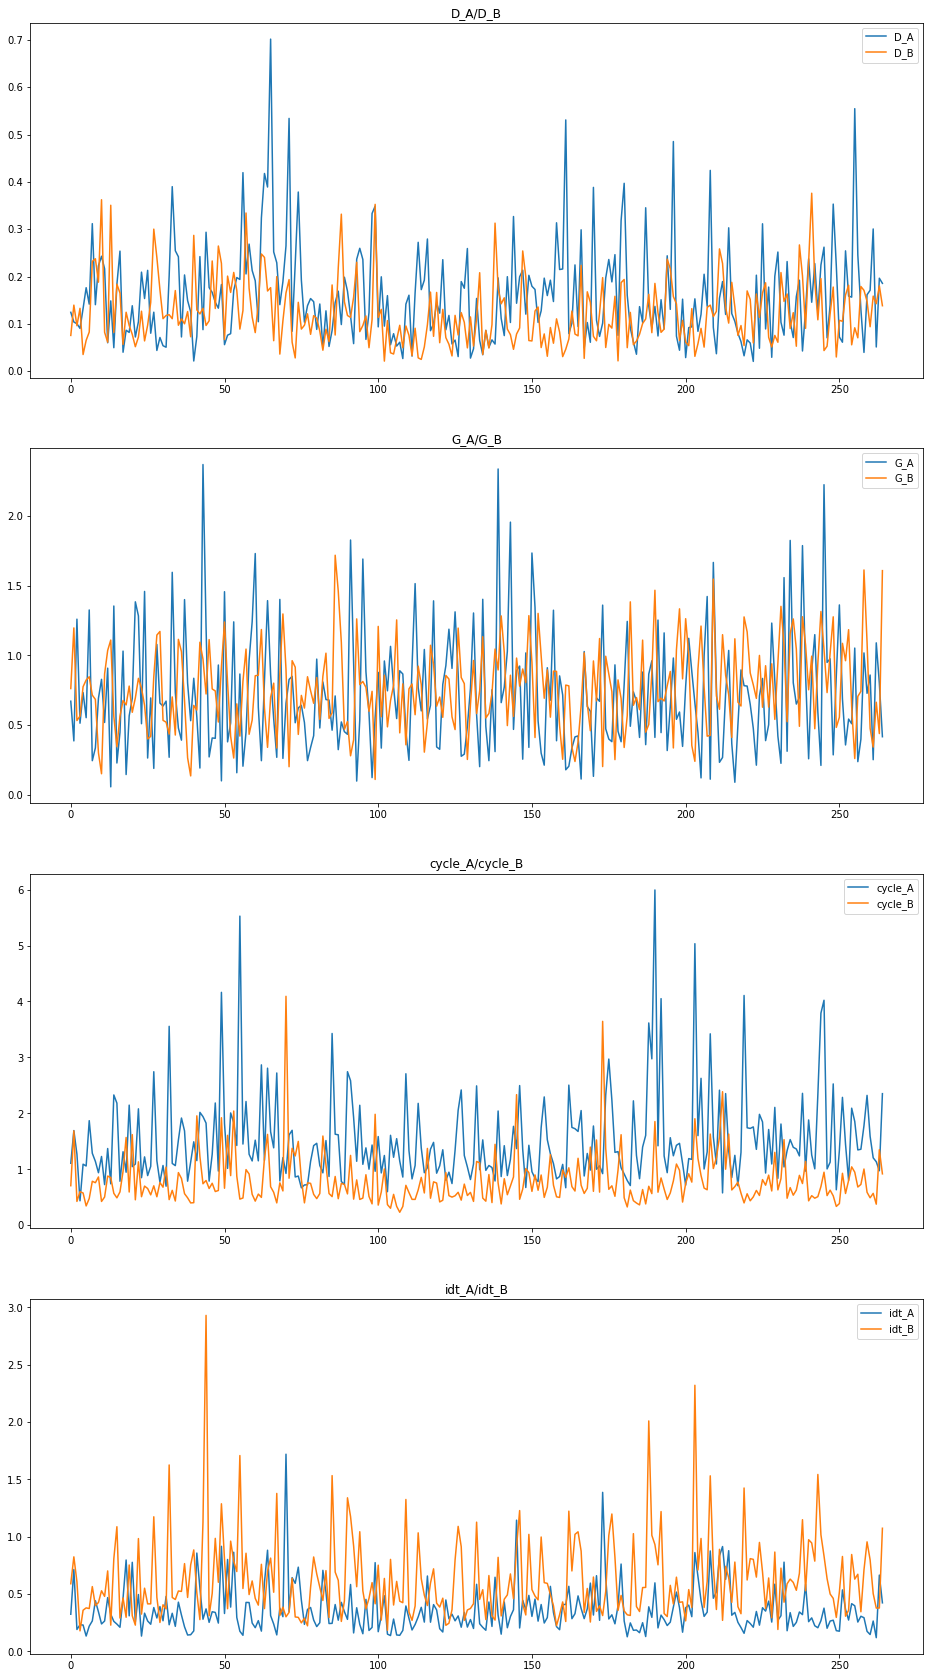

In [ ]:

for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):    # outer loop for different epochs; we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>
    epoch_start_time = time.time()  # timer for entire epoch
    iter_data_time = time.time()    # timer for data loading per iteration
    epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch
    visualizer.reset()              # reset the visualizer: make sure it saves the results to HTML at least once every epoch
    all_losses = defaultdict(list)

    for i, data in enumerate(dataset):  # inner loop within one epoch
        iter_start_time = time.time()  # timer for computation per iteration
        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time

        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)         # unpack data from dataset and apply preprocessing
        model.optimize_parameters()   # calculate loss functions, get gradients, update network weights

        if total_iters % opt.display_freq == 0:   # display images on visdom and save images to a HTML file
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result, jupyter=True)
            
        losses = model.get_current_losses()
        all_losses['D_A'].append(losses['D_A'])
        all_losses['G_A'].append(losses['G_A'])
        all_losses['cycle_A'].append(losses['cycle_A'])
        all_losses['idt_A'].append(losses['idt_A'])

        all_losses['D_B'].append(losses['D_B'])
        all_losses['G_B'].append(losses['G_B'])
        all_losses['cycle_B'].append(losses['cycle_B'])
        all_losses['idt_B'].append(losses['idt_B'])
        
        if total_iters % 1 == 0:    # print training losses and save logging information to the disk

            t_comp = (time.time() - iter_start_time) / opt.batch_size
            display.clear_output(wait=True)
            fig = plt.figure(figsize=(16, 30))
            
            plt.subplot(4,1,1)
            plt.title('D_A/D_B')       
            plt.plot(all_losses['D_A'], label = 'D_A')
            plt.plot(all_losses['D_B'], label = 'D_B' )
            plt.legend(loc="upper right")

            
            plt.subplot(4,1,2)
            plt.title('G_A/G_B')
            plt.plot(all_losses['G_A'], label = 'G_A')
            plt.plot(all_losses['G_B'], label ='G_B' )
            plt.legend(loc="upper right")
            
            plt.subplot(4,1,3)
            plt.title('cycle_A/cycle_B')
            plt.plot(all_losses['cycle_A'], label = 'cycle_A' )
            plt.plot(all_losses['cycle_B'], label = 'cycle_B')
            plt.legend(loc="upper right")
            
            plt.subplot(4,1,4)
            plt.title('idt_A/idt_B')          
            plt.plot(all_losses['idt_A'] , label = 'idt_A')
            plt.plot(all_losses['idt_B'], label = 'idt_B' )
            plt.legend(loc="upper right")
            
            plt.show()
#             visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
#             if opt.display_id == 0:
#                 visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses, jupyter=True)

        if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)

        iter_data_time = time.time()
    if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))
    model.update_learning_rate()                     # update learning rates at the end of every epoch.